# Bayesian Multinomial Logistic Regression

Model for 2 or more possible discrete outcomes, using iris dataset.

In [1]:
# Load Turing.
using Turing

# Load RDatasets.
using RDatasets

# Load StatsPlots for visualizations and diagnostics.
using StatsPlots

# Functionality for splitting and normalizing the data.
using MLDataUtils: shuffleobs, splitobs, rescale!

# We need a softmax function which is provided by NNlib.
using NNlib: softmax

# Set a seed for reproducibility.
using Random
Random.seed!(0);


## Data import and setup

In [2]:
# Import the "iris" dataset.
data = RDatasets.dataset("datasets", "iris");

# Show twenty random rows.
data[rand(1:size(data, 1), 10), :]

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,6.8,3.0,5.5,2.1,virginica
2,5.1,3.8,1.5,0.3,setosa
3,6.1,2.8,4.0,1.3,versicolor
4,5.7,4.4,1.5,0.4,setosa
5,6.9,3.1,5.4,2.1,virginica
6,5.6,3.0,4.1,1.3,versicolor
7,7.2,3.2,6.0,1.8,virginica
8,6.0,3.0,4.8,1.8,virginica
9,6.6,2.9,4.6,1.3,versicolor


Encoding labels

In [3]:
# Recode the `Species` column.
species = ["setosa", "versicolor", "virginica"]
data[!, :Species_index] = indexin(data[!, :Species], species)

# Show twenty random rows of the new species columns
data[rand(1:size(data, 1), 10), [:Species, :Species_index]]

,Species,Species_index
,Cat…,Union…
1,versicolor,2
2,virginica,3
3,versicolor,2
4,setosa,1
5,setosa,1
6,setosa,1
7,versicolor,2
8,versicolor,2
9,setosa,1


In [4]:
# Split our dataset 50%/50% into training/test sets.
trainset, testset = splitobs(shuffleobs(data), 0.5)

# Define features and target.
features = [:SepalLength, :SepalWidth, :PetalLength, :PetalWidth]
target = :Species_index

# Turing requires data in matrix and vector form.
train_features = Matrix(trainset[!, features])
test_features = Matrix(testset[!, features])
train_target = trainset[!, target]
test_target = testset[!, target]

# Standardize the features.
μ, σ = rescale!(train_features; obsdim = 1)
rescale!(test_features, μ, σ; obsdim = 1);

## Model Declaration

Now we can define a model. Assume a normal documentaion with mean 0, std $\sigma$.

In [5]:
@model function logistic_regression(x, y, σ)
    n = size(x, 1)
    # Sanity check
    length(y) == n || throw(DimensionMismatch("Number of observations are not equal"))
    
    # Priors
    intercept_versicolor ~ Normal(0, σ)
    intercept_virginica ~ Normal(0, σ)
    coefficients_versicolor ~ MvNormal(4, σ)
    coefficients_virginica ~ MvNormal(4, σ)
    
    # Compute likelihood
    values_versicolor = intercept_versicolor .+ x * coefficients_versicolor
    values_virginica = intercept_virginica .+ x * coefficients_virginica
    
    for i in 1:n
        # 0 correspoinds to setosa
        v = softmax([0, values_versicolor[i], values_virginica[i]])
        y[i] ~ Categorical(v)
    end
end;

In [6]:
chain = sample(logistic_regression(train_features, train_target, 1), HMC(0.05, 10), MCMCThreads(), 1500, 3)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\tburch\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:228


Chains MCMC chain (1500×19×3 Array{Float64,3}):

Iterations        = 1:1500
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 1500
parameters        = coefficients_versicolor[1], coefficients_versicolor[2], coefficients_versicolor[3], coefficients_versicolor[4], coefficients_virginica[1], coefficients_virginica[2], coefficients_virginica[3], coefficients_virginica[4], intercept_versicolor, intercept_virginica
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
                  parameters      mean       std   naive_se      mcse        e ⋯
                      Symbol   Float64   Float64    Float64   Float64    Float ⋯

  coefficients_versicolor[1]    1.0732    0.6568     0.0098    0.0333   418.47 ⋯
  coefficients_versicolor[2]   -1.4924    0.5760     0.0086    0.0248   548.57 ⋯
  coefficients_versicolor[3]    0.9889    0.7314     0.0109    0.0345   435.5

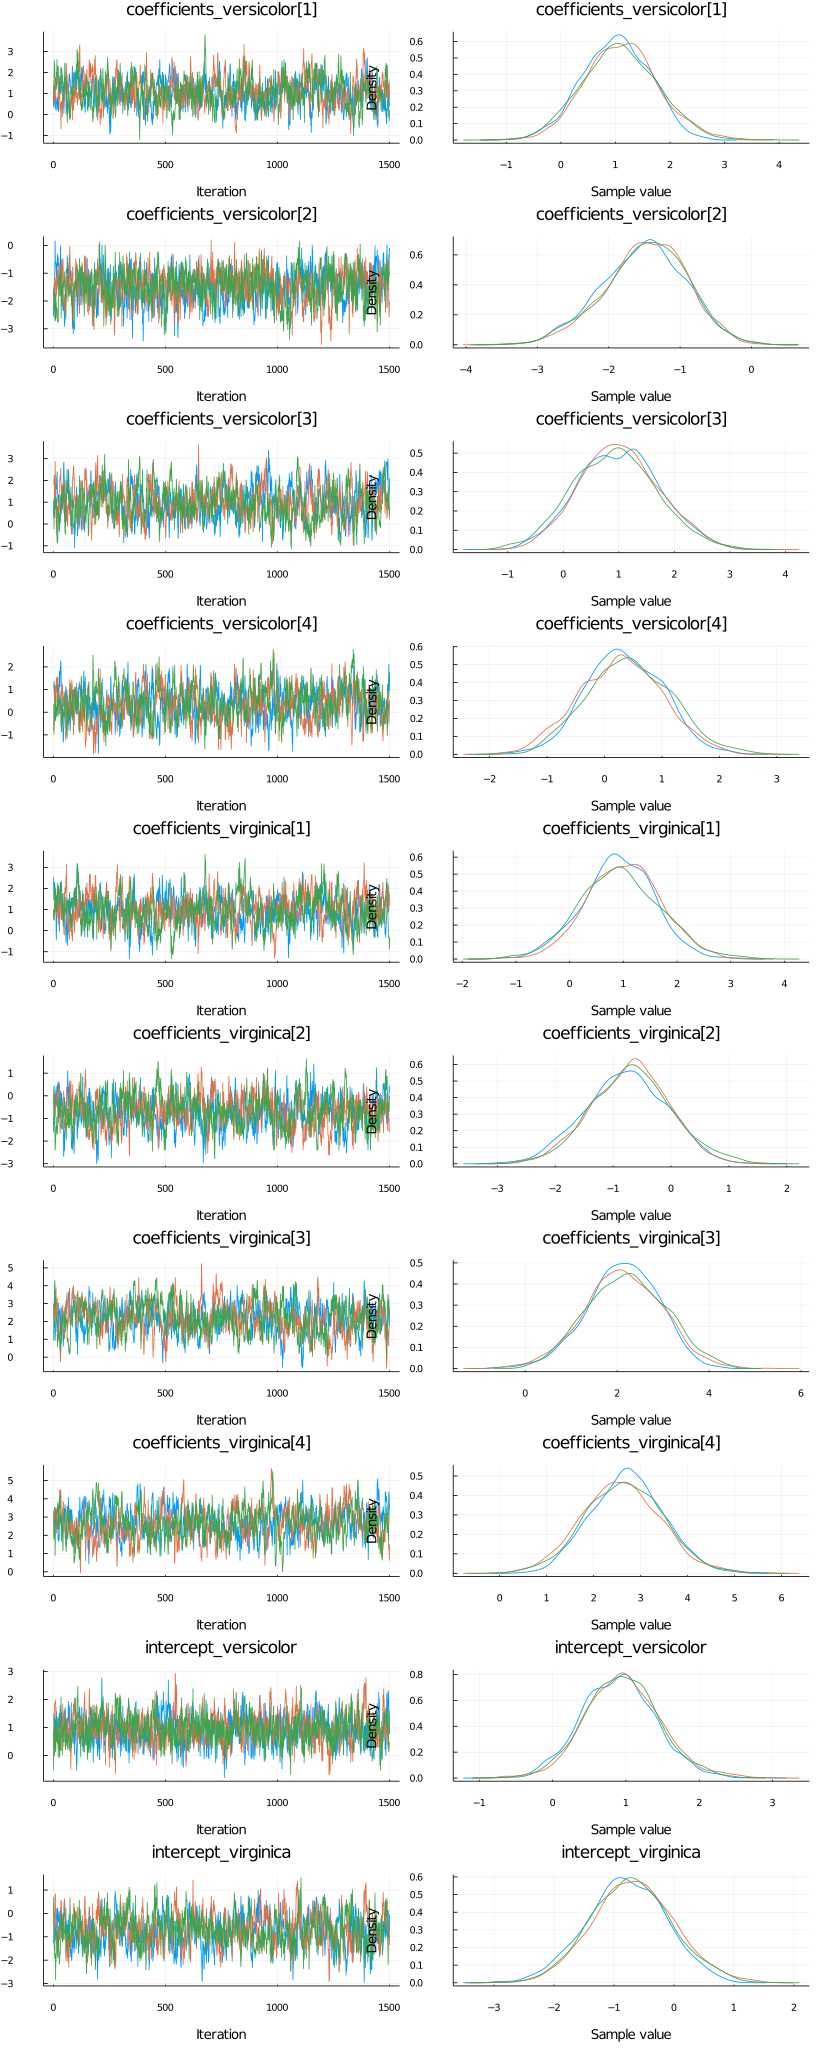

In [7]:
plot(chain)

This looks reasonable. Next to show the distributions of various parameters:

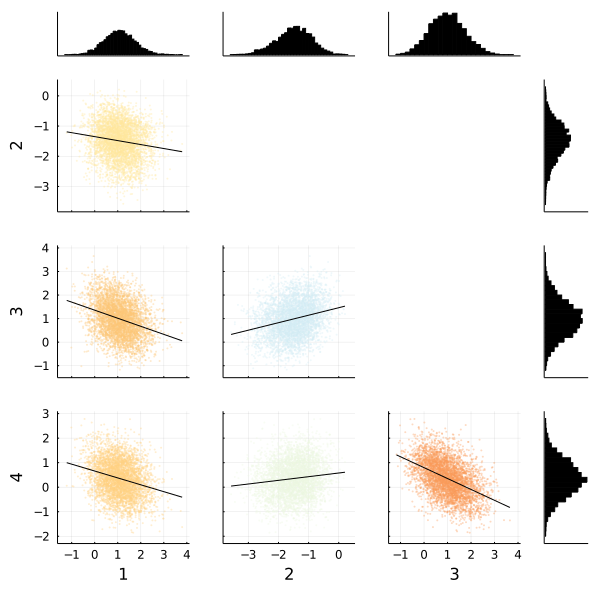

In [8]:
corner(
    chain, [Symbol("coefficients_versicolor[$i]") for i in 1:4];
    label=[string(i) for i in 1:4], fmt=:png
)

### Making Predictions

Build a prediction function with new data imputs and chains to predict

In [9]:
function prediction(x::Matrix, chain)
    # Pull the means from each parameter's sampled values in the chain.
    intercept_versicolor = mean(chain, :intercept_versicolor)
    intercept_virginica = mean(chain, :intercept_virginica)
    coefficients_versicolor = [mean(chain, "coefficients_versicolor[$i]") for i in 1:4]
    coefficients_virginica = [mean(chain, "coefficients_virginica[$i]") for i in 1:4]

    # Compute the index of the species with the highest probability for each observation.
    values_versicolor = intercept_versicolor .+ x * coefficients_versicolor
    values_virginica = intercept_virginica .+ x * coefficients_virginica
    species_indices = [argmax((0, x, y)) for (x, y) in zip(values_versicolor, values_virginica)]
    
    return species_indices
end;

In [10]:
predictions = prediction(test_features, chain)

mean(predictions .== testset[!, :Species_index])

0.92

Pretty good - breaking down by class:

In [11]:
for s in 1:3
    rows = testset[!, :Species_index] .== s
    println("Number of `", species[s], "`: ", count(rows))
    println("Percentage of `", species[s], "` predicted correctly: ", mean(predictions[rows] .== testset[rows, :Species_index]))
end

Number of `setosa`: 24
Percentage of `setosa` predicted correctly: 0.9583333333333334
Number of `versicolor`: 25
Percentage of `versicolor` predicted correctly: 0.88
Number of `virginica`: 26
Percentage of `virginica` predicted correctly: 0.9230769230769231
